# EAM PHAR1019 Endocrine and Metabolism

## Data Generator for the Experimental Design Coursework Task

<div style="
    background-color: #fff8e1;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #f9a825;
">

**Purpose:** This markdown worksheet generates synthetic data for use in the EAM PHAR1019 coursework task.

</div>

<div style="
    background-color: #fff8e1;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #f9a825;
">

**How to use:**

Refer to the coursework task description for details about the task itself.

This data generater has THREE points of input for students; these are preceeded by cells highlighted in green, containing instructions for these inputs.

The 3 input choices are
1. Select 1 variable to change
2. Select a value for that variable
3. Decide which timepoints you wish to measure
</div>

<div style="
    background-color: #fff8e1;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #f9a825;
">

**All cells MUST be run to be able to execute the script.** This includes hidden and collapsed cells.

The best way to do this is to click the ⏩ *'Restart the kernel and run all cells'* in the menu bar above. After this, you can run individual cells sequentially to update the graphs with your input using the ▶ *Run this cell and advance* button if you wish.


**Text entry values must be entered exactly as shown** in the comments. This includes spelling AND capitalisation.

</div>

The next 4 cells have to be run but must not be edited. The cells have been collapsed to streamline the workbook.

In [1]:
# Import packages (DO NOT EDIT)
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Functions (DO NOT EDIT)
# -----------------------------
def get_schedule(schedule_id: str) -> np.ndarray:
    schedules = {
        "sparse":      np.array([0, 30, 60, 120, 240, 360], dtype=float),
        "dense_early": np.array([0, 10, 20, 30, 45, 60, 120, 240, 360], dtype=float),
    }
    if schedule_id not in schedules:
        raise ValueError(f"schedule_id must be one of {list(schedules)}")
    return schedules[schedule_id]


def generate_glucose_timecourses_two_viscosities(
    viscosities=(0.8, 1.6),
    dose_units=(8, 8),
    times_min=None,
    repeats=4,
    baseline=7.0,
    noise_sd=0.25,
    seed=1
) -> pd.DataFrame:
    """
    Returns tidy df with columns:
      viscosity_Pa_s, dose_units, rep, time_min, glucose
    """
    rng = np.random.default_rng(seed)
    if times_min is None:
        times_min = np.array([0, 15, 30, 60, 120, 240, 360], dtype=float)

    rows = []
    for visc, dose in zip(viscosities, dose_units):
        v = float(visc)

        # Kinetic scaling: higher viscosity -> slower onset + longer duration
        tau_fast = 25.0 * (v ** 1.2)      # onset timescale
        tau_slow = 160.0 * (v ** 0.6)     # duration timescale

        # Dose scales effect magnitude (keep simple)
        A = 3.0 * (dose / 8.0)

        for rep in range(repeats):
            base_rep = baseline + rng.normal(0, 0.3)

            t = times_min
            kernel = np.exp(-t / tau_slow) - np.exp(-t / tau_fast)
            kernel = np.maximum(kernel, 0.0)
            kernel = kernel / (kernel.max() + 1e-9)

            glucose_true = base_rep - A * kernel
            glucose_obs = glucose_true + rng.normal(0, noise_sd, size=len(t))

            for ti, gi in zip(t, glucose_obs):
                rows.append({
                    "viscosity_Pa_s": v,
                    "dose_units": float(dose),
                    "rep": rep,
                    "time_min": float(ti),
                    "glucose_mmol_L": float(gi),
                })

    return pd.DataFrame(rows)


def build_single_settings_from_gated_input():
    ALLOWED = {
        "viscosity": ("viscosity_Pa_s", "viscosity_values", (0.2, 4.0)),
        "dose":      ("dose_units",    "dose_values",      (1, 12)),
        "repeats":    ("repeats",        "repeats_values",    (1, 10)),
        "schedule":  ("schedule_id",   "schedule_values",  ("sparse", "dense_early")),
    }

    if vary_parameter not in ALLOWED:
        raise ValueError(f"vary_parameter must be one of {list(ALLOWED)}")

    param_key, list_name, bounds = ALLOWED[vary_parameter]
    selected_values = globals().get(list_name)

    if selected_values is None:
        raise ValueError(f"You selected '{vary_parameter}' but did not provide {list_name}.")

    # Ensure only ONE list is filled
    for k, (_, other_list_name, _) in ALLOWED.items():
        if k != vary_parameter and globals().get(other_list_name) is not None:
            raise ValueError(
                f"Only one parameter may be varied. You selected '{vary_parameter}', "
                f"but also provided {other_list_name}."
            )

    # Require exactly one value (ONE new experiment)
    if not isinstance(selected_values, (list, tuple)) or len(selected_values) != 1:
        raise ValueError(f"Provide exactly ONE value in {list_name}, e.g. [{DEFAULTS[param_key]}].")

    value = selected_values[0]

    # Validate value/range
    if vary_parameter in ("viscosity", "dose", "n_reps"):
        lo, hi = bounds
        if not (lo <= value <= hi):
            raise ValueError(f"{vary_parameter} value {value} outside allowed range [{lo}, {hi}]")
    elif vary_parameter == "schedule":
        if value not in bounds:
            raise ValueError(f"schedule '{value}' must be one of {bounds}")

    settings = dict(DEFAULTS)
    settings[param_key] = value
    return settings


def plot_overlay_original_and_new(df_original, df_new, title, jitter_min=2.5):
    plt.figure(figsize=(8, 5))
    rng = np.random.default_rng(0)

    # Choose correct glucose column
    ycol = "glucose_mmol_L" if "glucose_mmol_L" in df_original.columns else "glucose"

    # --- Original experiments (two viscosities) ---
    for visc in sorted(df_original["viscosity_Pa_s"].unique()):
        d = df_original[df_original["viscosity_Pa_s"] == visc].copy()
        xj = rng.normal(0, jitter_min, size=len(d))
        plt.scatter(d["time_min"] + xj, d[ycol], alpha=0.12, s=30)

        mean = d.groupby("time_min", as_index=False)[ycol].mean()

        dose = d["dose_units"].iloc[0]
        repeats = d["rep"].nunique()

        plt.plot(
            mean["time_min"],
            mean[ycol],
            linestyle="--",
            linewidth=2,
            label=(
                f"original | η={visc:.2g} Pa·s, "
                f"dose={dose:g} U, "
                f"repeats={repeats}"
            )
        )

    # --- New experiment ---
    d = df_new.copy()
    xj = rng.normal(0, jitter_min, size=len(d))
    plt.scatter(d["time_min"] + xj, d[ycol], alpha=0.5, s=35)

    mean = d.groupby("time_min", as_index=False)[ycol].mean()

    visc_new = d["viscosity_Pa_s"].iloc[0]
    dose_new = d["dose_units"].iloc[0]
    repeats_new = d["rep"].nunique()

    plt.plot(
        mean["time_min"],
        mean[ycol],
        marker="o",
        linewidth=2,
        markersize=5,
        label=(
            f"new | η={visc_new:.2g} Pa·s, "
            f"dose={dose_new:g} U, "
            f"repeats={repeats_new}"
        )
    )

    plt.xlabel("Time (min)")
    plt.ylabel("Blood glucose (mmol/L)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()



# -----------------------------
# Summary table of experiment parameters (original visc=0.8, original visc=1.6, and new)
# -----------------------------
def summarise_experiment_params(df_original: pd.DataFrame, df_new: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a compact table with one row per experiment condition.
    """
    rows = []

    # Two original conditions (visc=0.8 and visc=1.6)
    for visc in sorted(df_original["viscosity_Pa_s"].unique()):
        d = df_original[df_original["viscosity_Pa_s"] == visc]
        rows.append({
            "experiment": "original",
            "viscosity_Pa_s": float(visc),
            "dose_units": float(d["dose_units"].iloc[0]),
            "repeats": int(d["rep"].nunique()),
            "schedule_id": "handout_fixed",
            "timepoints_min": list(sorted(d["time_min"].unique()))
        })

    # New condition (single)
    rows.append({
        "experiment": "new",
        "viscosity_Pa_s": float(df_new["viscosity_Pa_s"].iloc[0]),
        "dose_units": float(df_new["dose_units"].iloc[0]),
        "repeats": int(df_new["rep"].nunique()),
        "schedule_id": str(df_new["schedule_id"].iloc[0]) if "schedule_id" in df_new.columns else "student_selected",
        "timepoints_min": list(sorted(df_new["time_min"].unique()))
    })

    return pd.DataFrame(rows)



def validate_timepoints(timepoints_min, t_min=0, t_max=360, n_points=6, require_zero=True):
    if not isinstance(timepoints_min, (list, tuple, np.ndarray)):
        raise ValueError("timepoints_min must be a list of numbers (minutes).")

    if len(timepoints_min) != n_points:
        raise ValueError(f"timepoints_min must contain exactly {n_points} values.")

    # convert + basic numeric checks
    tp = np.array(timepoints_min, dtype=float)

    if np.any(~np.isfinite(tp)):
        raise ValueError("All timepoints must be finite numbers.")

    if np.any(tp < t_min) or np.any(tp > t_max):
        raise ValueError(f"All timepoints must be within [{t_min}, {t_max}] minutes.")

    if require_zero and tp.min() != 0:
        # require exact 0 for clarity (simplest)
        raise ValueError("timepoints_min must include 0 minutes as the baseline measurement.")

    # strictly increasing (no duplicates, sorted)
    if not np.all(np.diff(tp) > 0):
        raise ValueError("timepoints_min must be strictly increasing (sorted, no duplicates).")

    return tp


def build_settings_from_single_variable(
    vary_parameter: str,
    variable,
    defaults=None
):
    """
    Validate a single student-controlled variable and return a full settings dict.
    """

    # Defaults (fixed unless varied)
    if defaults is None:
        defaults = {
            "viscosity_Pa_s": 1.6,
            "dose_units": 8,
            "repeats": 4,
            "seed": 7
        }

    PARAMETERS = {
        "viscosity": {
            "key": "viscosity_Pa_s",
            "min": 0.2,
            "max": 4.0,
            "type": float,
            "units": "Pa·s"
        },
        "dose": {
            "key": "dose_units",
            "min": 1,
            "max": 12,
            "type": float,
            "units": "U"
        },
        "repeats": {
            "key": "repeats",
            "min": 1,
            "max": 10,
            "type": int,
            "units": ""
        }
    }

    if vary_parameter not in PARAMETERS:
        raise ValueError(
            f"vary_parameter must be one of {list(PARAMETERS.keys())}"
        )

    param = PARAMETERS[vary_parameter]

    # Type validation
    try:
        value = param["type"](variable)
    except Exception:
        raise ValueError(
            f"Value for '{vary_parameter}' must be of type {param['type'].__name__}"
        )

    # Range validation
    if not (param["min"] <= value <= param["max"]):
        raise ValueError(
            f"{vary_parameter} must be between "
            f"{param['min']} and {param['max']} {param['units']}"
        )

    # Build final settings
    settings = dict(defaults)
    settings[param["key"]] = value

    return settings




In [3]:
# Recreate the first two experiments for comparison (DO NOT EDIT)
# -----------------------------
df_original = generate_glucose_timecourses_two_viscosities(
    viscosities=(0.6, 1.2),
    dose_units=(10, 8),
    times_min=np.array([0, 15, 30, 60, 120, 240, 360], dtype=float),
    repeats=4,
    baseline=7.0,
    noise_sd=0.25,
    seed=7
)
df_original["experiment"] = "original"

In [4]:
# Default settings for new experiment (DO NOT EDIT)
# -----------------------------
DEFAULTS = {
    "viscosity_Pa_s": 1.2,
    "dose_units": 8,
    "repeats": 4,
    "seed": 7
}

<div style="
    background-color: #e6f4ea;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #2e7d32;
">

### Student Input 1

</div>

<div style="
    background-color: #e6f4ea;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #2e7d32;
">
    
Select **ONE** variable for which you wish to enter a new value for the next experiment.

The name of the variable must be placed between commas: "VARIABLE_NAME". Below, this is shown in the default parameter *"viscosity"*, coloured in red.

</div>

In [5]:
###### ============================================
# STUDENT INPUT 1 (edit here)
# ============================================
# Select ONE parameter to vary:
vary_parameter = "viscosity"   # allowed values: "viscosity" or "dose" or "repeats
# ============================================

<div style="
    background-color: #e6f4ea;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #2e7d32;
">

### Student Input 2

</div>

<div style="
    background-color: #e6f4ea;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #2e7d32;
">

Enter a value for your chosen variable below.

In the code, the ranges from which you can select has been contrained to ensure interpretable outputs are generated. The ranges are different for each variable. Select **ONE** value from the range that applies to your selected variable.

The **permitted ranges** are:

**Viscosity:** 0.2 - 4.0 Pa·s

**Dose:** 1 - 12 U

**Repeats:** 1 - 10

</div>

In [6]:
# ============================================
# STUDENT INPUT 2 (edit here)
# ============================================
# Enter ONE value for the selected parameter
variable = 0.6   # allowed ranges: viscosity: 0.2 – 4.0 Pa·s | dose: 1 – 12 U | repeats: 1 – 10
# ============================================

The other two variables will be set to default values (this was set in one of the previous cells).

**Default values:**

**Viscosity:** 1.6 Pa·s

**Dose:** 8 U

**Repeats:** 4

Next, the settings for the new experiments are compiled so it can be fed back into the synthetic data generator.

**If this operation produces an error, check that**
1. You have spelled your selected variable correctly.
2. The value you entered is within the allwoed range for that variable.
3. Ensure you have run all cells in the workbook.

In [7]:
# Compile list of parameter values for new experiment (DO NOT EDIT)
# -----------------------------------------------------------------
settings = build_settings_from_single_variable(
    vary_parameter=vary_parameter,
    variable=variable
)

viscosity_Pa_s = settings["viscosity_Pa_s"]
dose_units     = settings["dose_units"]
repeats        = settings["repeats"]
seed           = settings["seed"]

Here is a summary of the settings for your experiment.

In [8]:
# Return settings for checking (DO NOT EDIT)
# ------------------------------------------
settings

{'viscosity_Pa_s': 0.6, 'dose_units': 8, 'repeats': 4, 'seed': 7}

<div style="
    background-color: #e6f4ea;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #2e7d32;
">

### Student Input 3

</div>

<div style="
    background-color: #e6f4ea;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #2e7d32;
">

Decide which 7 timepoints you would like to measure for your timecourse experiment.

If left 'as-is' the timepoints will be the same as for the initial two datasets.

You can choose to measure at other timepoints, e.g., to get a denser, more detailed dataset at the early, middle or late state of the timecourse. Wether this is helpful or not will depend on your scientific question.

You must select 7 timepoints. These must be entered in increasing order.

</div>

In [9]:
# ============================================
# STUDENT INPUT 3 (edit here)
# ============================================
# Choose exactly 7 sampling timepoints (minutes)
# Rules:
#   - exactly 7 values
#   - within 0 to 360
#   - strictly increasing
# ============================================
timepoints_min = [0, 15, 30, 60, 120, 240, 360]

The code below checks if your timepoint entries are valid. If it produces an error, check that your entries comply with the requirements.

In [10]:
# Generate timecourse timepoints for new experiment (DO NOT EDIT)
# ---------------------------------------------------------------
times_new = validate_timepoints(timepoints_min, t_min=0, t_max=360, n_points=7, require_zero=True)
times_new

array([  0.,  15.,  30.,  60., 120., 240., 360.])

Now, it is time to generate your dataset using your selected parameters.

In [11]:
# Student dataset for new experiment (DO NOT EDIT)
# ------------------------------------------------
df_new = generate_glucose_timecourses_two_viscosities(
    viscosities=(viscosity_Pa_s,),
    dose_units=(dose_units,),
    times_min=times_new,
    repeats=repeats,
    baseline=7.0,
    noise_sd=0.25,
    seed=seed
)
df_new["experiment"] = "new"

Let's check that you have data for your new experiment by looking at the first 5 rows of your table (dataframe).

In [12]:
df_new.head()

,viscosity_Pa_s,dose_units,rep,time_min,glucose_mmol_L,experiment
0,0.6,8.0,0,0.0,7.075055,new
1,0.6,8.0,0,15.0,4.454065,new
2,0.6,8.0,0,30.0,3.777721,new
3,0.6,8.0,0,60.0,4.233948,new
4,0.6,8.0,0,120.0,5.127090,new


The code below plots your dataset in green as an overlay with the two initial datasets (in blue and orange). The overlay ismeant to help with the comparison of the effect of your chosen variable and value on the system.

**Copy this plot into your coursework report and use it to answer the relevant questions.**

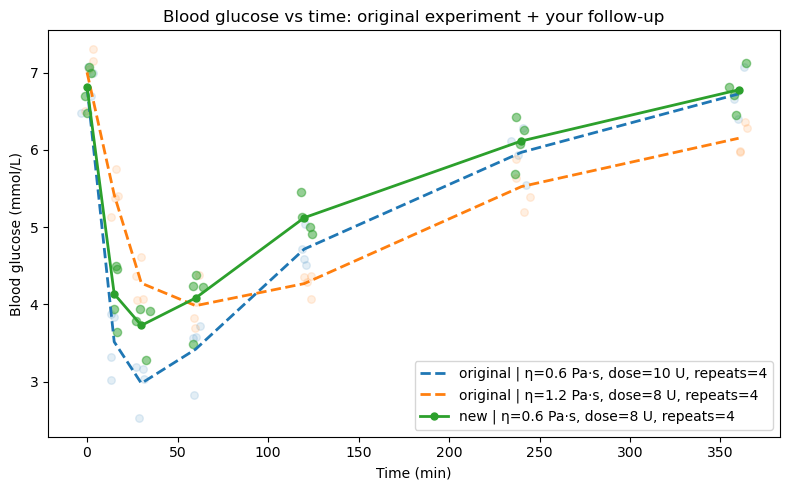

In [13]:
# -----------------------------
# Plot overlay
# -----------------------------
plot_overlay_original_and_new(
    df_original=df_original,
    df_new=df_new,
    title="Blood glucose vs time: original experiment + your follow-up"
)

Below is a table that summarises and compares the input variables for all three experiments - the 2 initial experiemnts and your new experiment.

In [14]:
df_params = summarise_experiment_params(df_original, df_new)
df_params

,experiment,viscosity_Pa_s,dose_units,repeats,schedule_id,timepoints_min
0,original,0.6,10.0,4,handout_fixed,"[0.0, 15.0, 30.0, 60.0, 120.0, 240.0, 360.0]"
1,original,1.2,8.0,4,handout_fixed,"[0.0, 15.0, 30.0, 60.0, 120.0, 240.0, 360.0]"
2,new,0.6,8.0,4,student_selected,"[0.0, 15.0, 30.0, 60.0, 120.0, 240.0, 360.0]"


<div style="
    background-color: #fff8e1;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #f9a825;
">

## Troubleshooting for the Code
</div>

<div style="
    background-color: #fff8e1;
    padding: 12px 16px;
    border-radius: 6px;
    border-left: 5px solid #f9a825;
">

If your code does not complete, check that

1. You have spelled your selected variable correctly.
2. The values you entered for your variable AND your timepoints are within the allowed range and in the correct format.
3. Ensure you have run all cells in the workbook. - Use ⏩ *'Restart the kernel and run all cells'* in the menu bar above to re-run the code from the beginning if necessary.
4. Close the browser (and clear your cache) and then click the link again to start with a new workbook, if you think that some of the other code cells were altered.
</div>